# 正則化
- scikit-learnを用いてモデルの正則化を実装しよう

## 1. ライブラリの読み込み

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 線形回帰モデル
from sklearn.linear_model import LinearRegression 
# 正則化つき線形回帰モデル
from sklearn.linear_model import Ridge,Lasso,ElasticNet 
# 多項式特徴量を計算する前処理用の関数
from sklearn.preprocessing import PolynomialFeatures
# 機械学習パイプラインを作成するための関数
from sklearn.pipeline import make_pipeline

## 2. 疑似データの生成
参考：
[Regularized Linear Regression with Scikit-learn](http://nbviewer.jupyter.org/urls/s3.amazonaws.com/datarobotblog/notebooks/regularized-linear-regression.ipynb)

(0.0, 1.0)

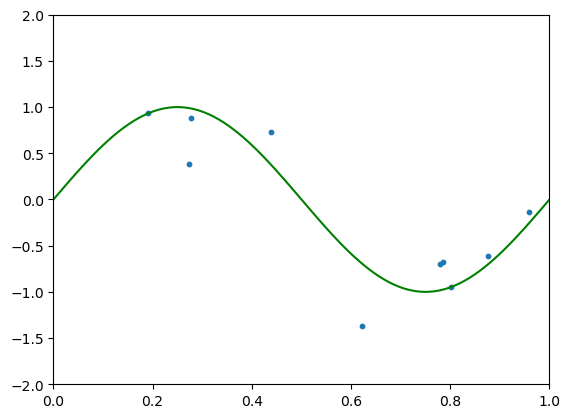

In [2]:
## ノイズのないデータの生成
# sin(2πx)を関数として定義
def f(x):
    return np.sin(2 * np.pi * x)

# x軸の値を生成
x_plot = np.linspace(0, 1, 100)
# きれいなsin関数を表示
plt.plot(x_plot, f(x_plot), color='green')

## ノイズのあるデータの生成
# サンプル数を設定
n_samples = 10
# 乱数シードを固定
np.random.seed(1234)

# x軸の値を生成
X = np.random.uniform(0, 1, size=n_samples)[:, np.newaxis]
# sin関数の値にノイズを加えて、ばらつきを表現
y = f(X) + np.random.normal(scale=0.3, size=n_samples)[:, np.newaxis] 
# ノイズのあるデータを表示
plt.scatter(X, y, s=10)

# 表示範囲の調整
plt.ylim((-2, 2))
plt.xlim((0, 1))

## 3. 正則化なしで学習
#### [PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)
- データから多項式特徴量を生成するメソッド
- 引数degreeで次数を設定
- 主に[pipeline()](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)の中に組み込んで、モデルの入力として使用
#### degreeの値による特徴量の違い
- degree=0:$y=a_0$  
- degree=1:$y=a_0+a_1x$  
- degree=3:$y=a_0+a_1x+a_2x^2+a_3x^3$  
- degree=9:$y=a_0+\sum_{i=1}^9 {a_ix^i}$  

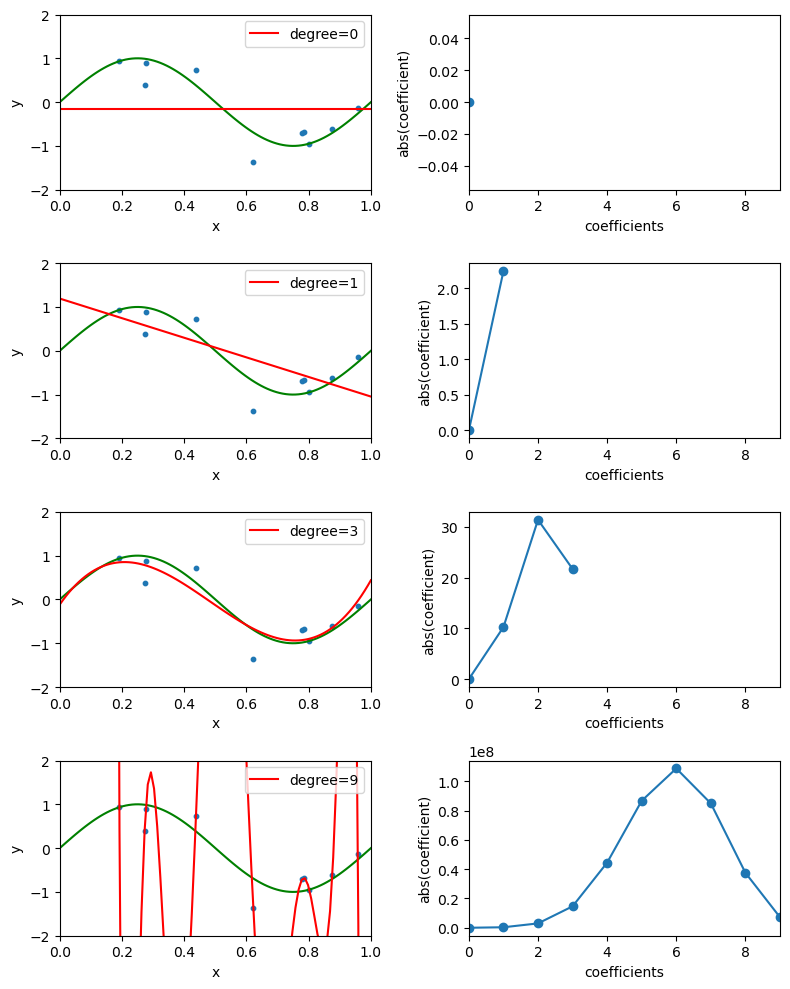

In [3]:
# 左側のグラフをまとめて描画する関数
def plot_approximation(est, ax, label=None):
    # 理想的なモデルを描画（緑色の線）
    ax.plot(x_plot, f(x_plot), color='green')
    # 学習用データを描画（青色の点）
    ax.scatter(X, y, s=10)
    # モデルの予測結果を描画（赤色の線）
    ax.plot(x_plot, est.predict(x_plot[:, np.newaxis]), color='red', label=label)
    # 表示範囲の調整
    ax.set_ylim((-2, 2))
    ax.set_xlim((0, 1))
    # 軸ラベルの設定
    ax.set_ylabel('y')
    ax.set_xlabel('x')
    # 凡例の表示位置を調整
    ax.legend(loc='upper right')  #, fontsize='small')

# 右側のグラフをまとめて描画する関数
def plot_coefficients(est, ax, label=None, yscale='log'):
    # 最後のステップ（線形回帰）の係数を取得
    coef = est.steps[-1][1].coef_.ravel()
    if yscale == 'log':
        # logスケールで描画する場合、係数の絶対値をとる
        coef = np.abs(coef) + 1e1 # log(0)を防ぐため
        # y軸を対数スケールに変更
        ax.semilogy(coef, marker='o', label=label)
        ax.set_ylim((1e-1, 1e8))
        ax.set_ylabel('abs(coefficient)  in log scale')
    else:
        ax.plot(np.abs(coef), marker='o', label=label)
        ax.set_ylabel('abs(coefficient)')
    
    ax.set_xlabel('coefficients')
    ax.set_xlim((0, 9))

    
# 4x2の描画エリアを作成
fig, ax_rows = plt.subplots(4, 2, figsize=(8, 10))

# 各行で異なる次数の多項式特徴量を作成
degrees = [0, 1, 3, 9]
# グラフを表示する場所（ax）を指定
for ax_row, degree in zip(ax_rows, degrees):
    ax_left, ax_right = ax_row
    # 多項式特徴量と線形回帰モデルを組み合わせたパイプラインを作成
    est = make_pipeline(
        PolynomialFeatures(degree), 
        LinearRegression()
    )
    # モデルを学習
    est.fit(X, y)
    # 予測結果と係数を描画
    plot_approximation(est, ax_left, label='degree=%d' % degree)
    plot_coefficients(est, ax_right, yscale=None)

# 各グラフの表示位置を調整   
plt.tight_layout()

- degree=0や1の場合、ほとんど学習データを表現することができていない
   - アンダーフィッティング（未学習）を起こしている
- degree=9になると、各係数の値が非常に大きくなっている
    - 係数の値が大きいと、$x$への寄与率が大きくなる
    - 既知のデータへの当てはまりは良くなるが、未知のデータ（テストデータ）への当てはまりがわるくなる
    - オーバーフィッティング（過学習）を起こしている

### [演習]
- degree=7の場合はどうなる？
- degree=20の場合はどうなる？
- データ点数(n_samples)とdegreeの値をいろいろ変えて、結果がどう変わるか確認してみよう

## 4. 正則化ありで学習
- Ridge
- Lasso
- ElasticNet

### 4-1. Ridge
- L2ノルムを最小化（L2正則化）
- 係数の値が小さくなる
- 引数`alpha`で正則化の強さを調整

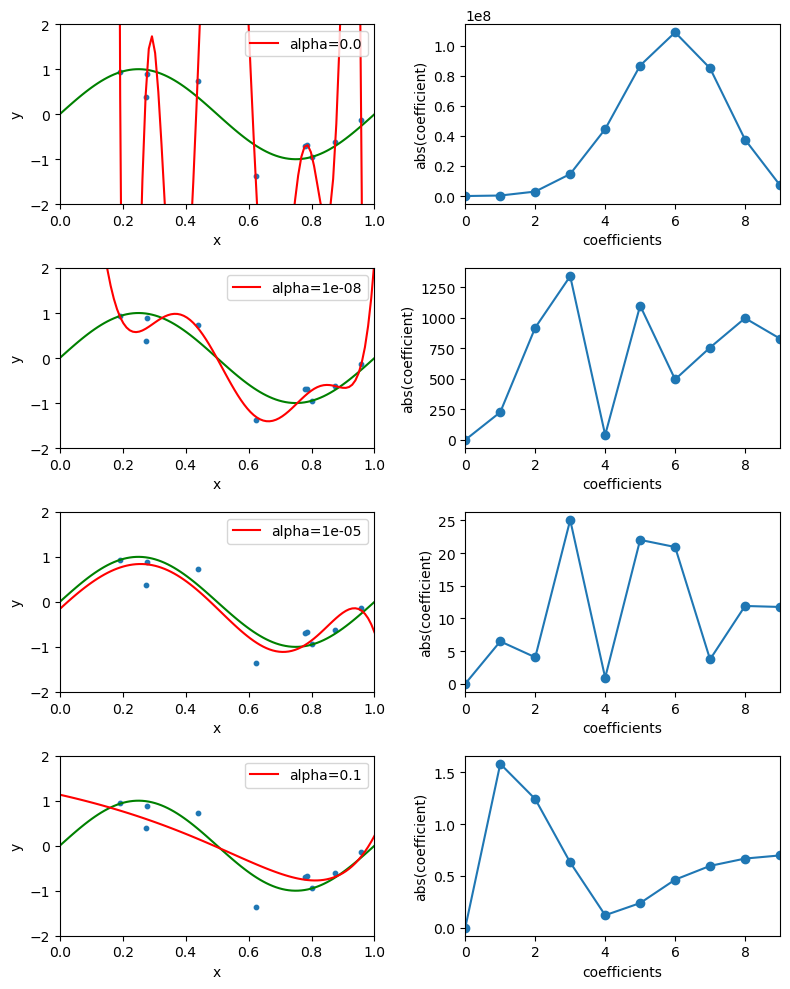

In [4]:
# 4x2の描画エリアを作成
fig, ax_rows = plt.subplots(4, 2, figsize=(8, 10))
# 多項式特徴量の次数を設定（9に固定）
degree = 9
#alpha(数式ではλ)の値を4つ指定する
alphas = [0.0, 1e-8, 1e-5, 1e-1]

# alphaを変えながら先程と同様のグラフを表示
for alpha, ax_row in zip(alphas, ax_rows):
    ax_left, ax_right = ax_row
    # 多項式特徴量とRidgeを組み合わせたパイプラインを作成
    # ConvergenceWarning（学習が収束しない）は、無視してよい
    est = make_pipeline(
        PolynomialFeatures(degree), 
        Ridge(alpha=alpha, random_state=1234)
    )
    # モデルを学習
    est.fit(X, y)
    # 予測結果と係数を描画
    plot_approximation(est, ax_left, label='alpha=%r' % alpha)
    plot_coefficients(est, ax_right, yscale=None)

# 各グラフの表示位置を調整    
plt.tight_layout()

alphaを大きくすると、係数の値が小さくなっていき、過学習が抑制されることがわかる

#### [演習] `alpha`の値をいろいろ変えて、結果がどう変わるか確認してみよう

### 4-2. Lasso
- L1ノルムを最小化（L1正則化）
- 値が0の係数が多くなる
- 引数`alpha`で正則化の強さを制御

F:\Anaconda3\envs\mlv4\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.382e-03, tolerance: 6.220e-04
  model = cd_fast.enet_coordinate_descent(


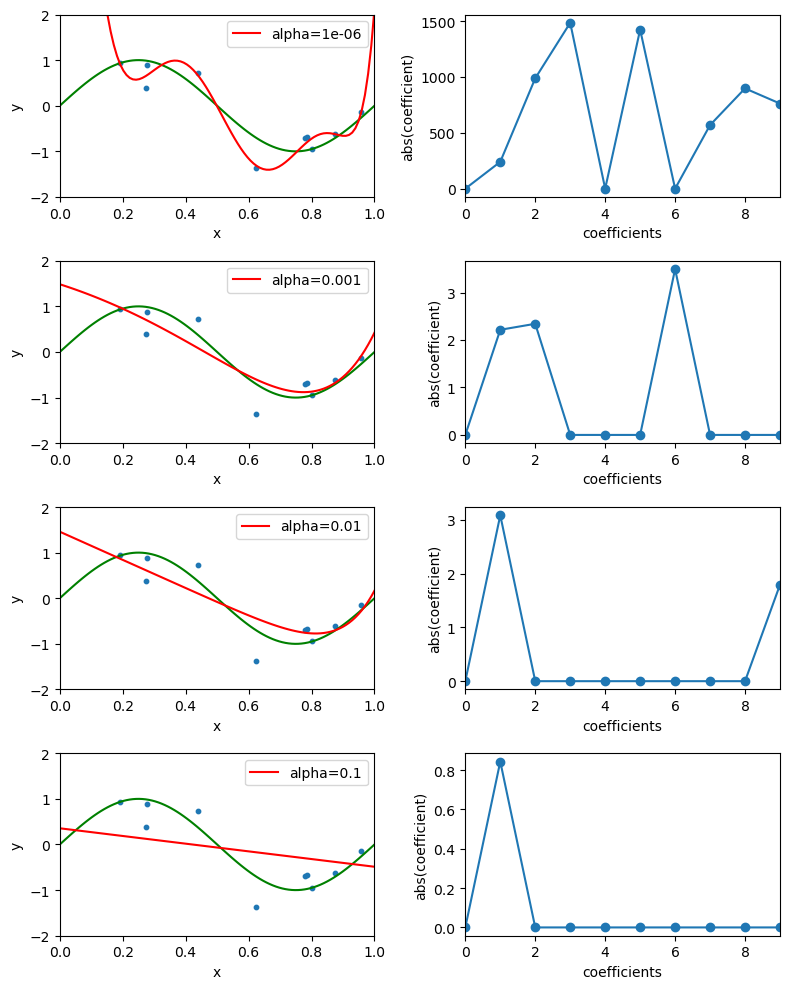

In [5]:
# 4x2の描画エリアを作成
fig, ax_rows = plt.subplots(4, 2, figsize=(8,10))
# 多項式特徴量の次数を設定（9に固定）
degree = 9
#alpha(数式ではλ)の値を4つ指定する
alphas = [1e-6, 1e-3, 1e-2, 1e-1]

# alphaを変えながら先程と同様のグラフを表示
for alpha, ax_row in zip(alphas, ax_rows):
    ax_left, ax_right = ax_row
    # 多項式特徴量とLassoを組み合わせたパイプラインを作成
    # ConvergenceWarning（学習が収束しない）は、無視してよい
    est = make_pipeline(
        PolynomialFeatures(degree), 
        Lasso(alpha=alpha,max_iter=int(1e8), random_state=1234)
    )
    # モデルを学習
    est.fit(X, y)
    # 予測結果と係数を描画
    plot_approximation(est, ax_left, label='alpha=%r' % alpha)
    plot_coefficients(est, ax_right, yscale=None)

# 各グラフの表示位置を調整    
plt.tight_layout()
plt.show()

alphaを大きくすると、0の係数が増えていき、過学習が抑制されることがわかる

#### [演習] `alpha`の値をいろいろ変えて、結果がどう変わるか確認してみよう

### 4-3. ElasticNet
- RidgeとLassoを組み合わせたもの
- L2/L1ノルムのバランスによって性質が変わる
- 引数`l1_ratio`でL1正則化とL2正則化のバランスを調整
    - 1に近いほどLassoに近い処理
    - 0に近いほどRidgeに近い処理

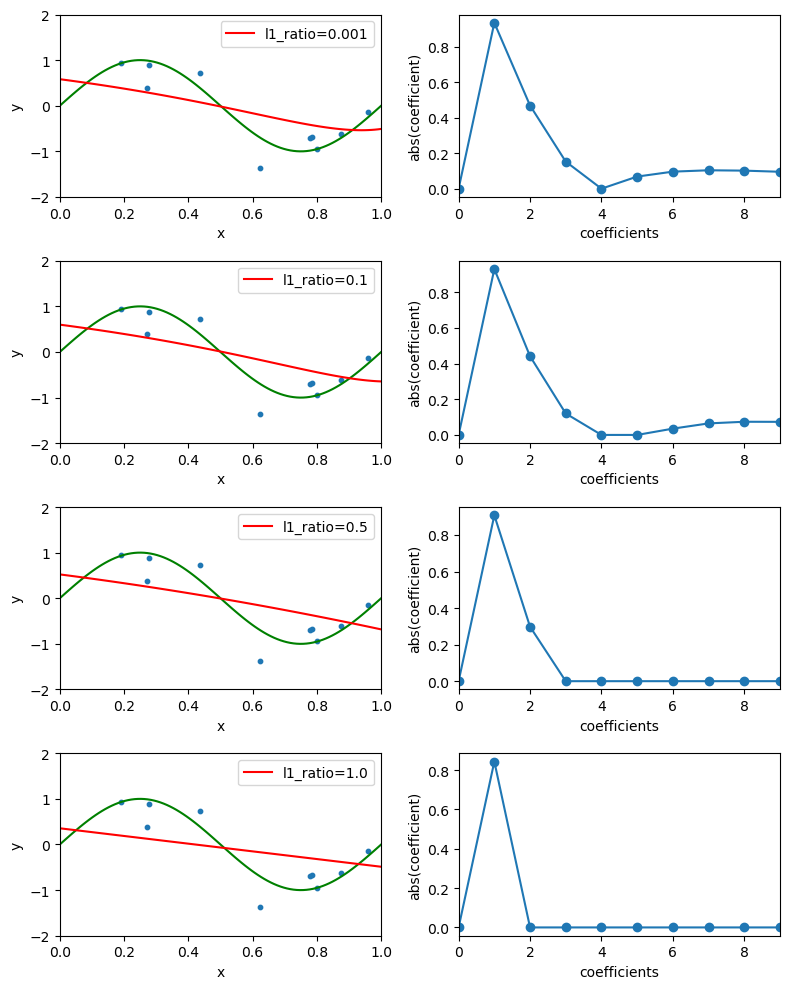

In [6]:
# 4x2の描画エリアを作成
fig, ax_rows = plt.subplots(4, 2, figsize=(8,10))
# 多項式特徴量の次数を設定（9に固定）
degree = 9
# 正則化全体の強さを指定
alpha = 1e-1
# L1正則化の強さを4つ指定する
# L2正則化の強さは1 - l1_ratioで自動的に設定される
l1_ratios = [0.001, 0.1, 0.5, 1.0]

# l1_ratioを変えながら先程と同様のグラフを表示
for l1_ratio, ax_row in zip(l1_ratios, ax_rows):
    ax_left, ax_right = ax_row
    # 多項式特徴量とElasticNetを組み合わせたパイプラインを作成
    # ConvergenceWarning（学習が収束しない）は、無視してよい
    est = make_pipeline(
        PolynomialFeatures(degree),
        ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=int(1e8), tol=1e7)
    )
    # モデルを学習
    est.fit(X, y)
    # 予測結果と係数を描画
    plot_approximation(est, ax_left, label='l1_ratio=%r' % l1_ratio)
    plot_coefficients(est, ax_right, yscale=None)

# 各グラフの表示位置を調整    
plt.tight_layout()

 - `l1_ratio` が小さければL2正則化の効果が強く現れ，逆に大きければL1正則化の効果が強く現れる

#### [演習] `alpha`や`l1_ratio`の値を変えて、結果がどう変わるか確認してみよう